In [0]:
# Install Pytesseract Library

!sudo apt install tesseract-ocr
!pip install pytesseract

In [0]:
# Import required packages

import numpy as np
import matplotlib.pyplot as plt
import re

from PIL import Image
import pytesseract as ocr

In [0]:
# Mount Google Drive if working on Colab

from google.colab import drive
drive.mount("/drive")

In [0]:
# Pre-process Input Image

input_path = "/drive/My Drive/Colab Notebooks/test.png"

img = Image.open(input_path)
img = img.convert(mode='RGBA')
pixels = img.load()

# Can be adjusted for better results
opacity_limit = 128

for x in range(img.size[0]):
    for y in range(img.size[1]):
        if pixels[x,y][0]<opacity_limit or pixels[x,y][1]<opacity_limit or pixels[x,y][2]<opacity_limit:
            pixels[x, y] = (0, 0, 0, 255)
        else:
            pixels[x, y] = (255, 255, 255, 255)

img.save("preprocessed_img.png")

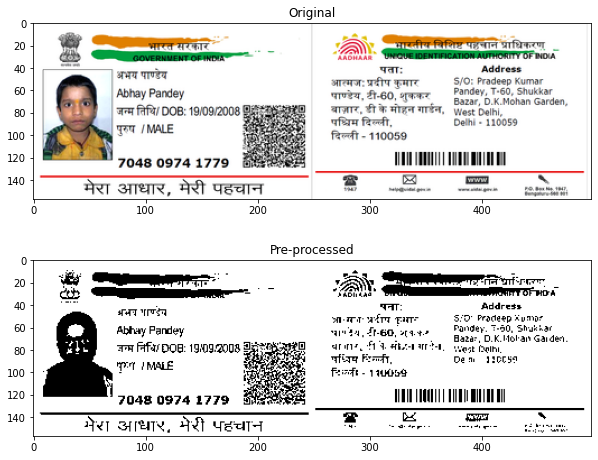

In [6]:
# Show Original and Preprocessed Images

plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("Original")
plt.imshow(Image.open(input_path))

plt.subplot(2,1,2)
plt.title("Pre-processed")
plt.imshow(Image.open("preprocessed_img.png"))

plt.show()

In [7]:
# OCR using Pytesseract

result = ocr.image_to_string(Image.open("preprocessed_img.png"),lang="eng")
bounding_boxes = ocr.image_to_boxes(Image.open("preprocessed_img.png"),lang="eng").split(" 0\n")

print(result)

> TT
axon
Abu Pandey
x Far DOB: 19099008 8
"pr IME

7048 0974 1779
ART AMY, AN) Gear

  

 

anne 8 dicaarta, ea bein
wire Dea Sboese
RoR rudee


In [0]:
# Verhoeff Algorithm

multiplication_table = (
    (0, 1, 2, 3, 4, 5, 6, 7, 8, 9),
    (1, 2, 3, 4, 0, 6, 7, 8, 9, 5),
    (2, 3, 4, 0, 1, 7, 8, 9, 5, 6),
    (3, 4, 0, 1, 2, 8, 9, 5, 6, 7),
    (4, 0, 1, 2, 3, 9, 5, 6, 7, 8),
    (5, 9, 8, 7, 6, 0, 4, 3, 2, 1),
    (6, 5, 9, 8, 7, 1, 0, 4, 3, 2),
    (7, 6, 5, 9, 8, 2, 1, 0, 4, 3),
    (8, 7, 6, 5, 9, 3, 2, 1, 0, 4),
    (9, 8, 7, 6, 5, 4, 3, 2, 1, 0))

permutation_table = (
    (0, 1, 2, 3, 4, 5, 6, 7, 8, 9),
    (1, 5, 7, 6, 2, 8, 3, 0, 9, 4),
    (5, 8, 0, 3, 7, 9, 6, 1, 4, 2),
    (8, 9, 1, 6, 0, 4, 3, 5, 2, 7),
    (9, 4, 5, 3, 1, 2, 6, 8, 7, 0),
    (4, 2, 8, 6, 5, 7, 3, 9, 0, 1),
    (2, 7, 9, 3, 8, 0, 6, 4, 1, 5),
    (7, 0, 4, 6, 9, 1, 3, 2, 5, 8))

def compute_checksum(number):
    
    """Calculate the Verhoeff checksum over the provided number. The checksum
    is returned as an int. Valid numbers should have a checksum of 0."""
    
    # transform number list
    number = tuple(int(n) for n in reversed(str(number)))
    
    # calculate checksum
    checksum = 0
    
    for i, n in enumerate(number):
        checksum = multiplication_table[checksum][permutation_table[i % 8][n]]
    
    return checksum

In [0]:
# Search Possible UIDs with Bounding Boxes

start_char_pos = 0

lines = result.split('\n')
possible_UIDs = []

for line in lines:
  
  words = line.split()

  if(len(words)==0):
    continue

  Combined = "".join(words)

  UID = re.search("[0-9]{12}",Combined)    

  if UID!=None:

    # Check Validity

    if compute_checksum(int(UID.group())) == 0:
      possible_UIDs.append([int(UID.group()),start_char_pos + UID.start()])

  start_char_pos += len(Combined)

# Get Unique Possible UIDs

possible_UIDs = np.unique(possible_UIDs,axis=0)

In [16]:
# Print Results

print(possible_UIDs[:,0])

[704809741779]


In [0]:
# Mask found UIDs

img = Image.open(input_path)
pixels = img.load()

for UID in possible_UIDs:

  top_corner = bounding_boxes[UID[1]].split()
  bottom_corner = bounding_boxes[UID[1] + 7].split()

  for x in range(int(top_corner[1]),int(bottom_corner[3])+1):
      for y in range(img.height-int(top_corner[4]),img.height-int(bottom_corner[2])+1):
          pixels[x, y] = (0,0,0)

img.save("masked_img.png")

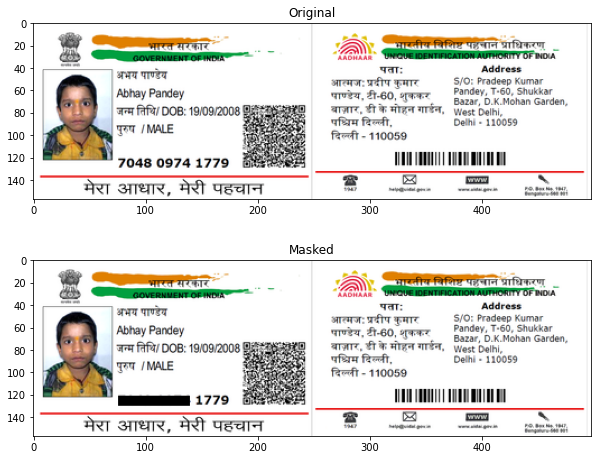

In [18]:
# Show Original and Masked Images

plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("Original")
plt.imshow(Image.open(input_path))

plt.subplot(2,1,2)
plt.title("Masked")
plt.imshow(Image.open("masked_img.png"))

plt.show()